In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torchsummary import summary
import pandas as pd
import time

In [2]:
#define a simple ANN.
class ANNModel(nn.Module):
    def __init__(self, input_size):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 128)         # Hidden layer 2
        self.fc3 = nn.Linear(128, 128)         # Hidden layer 3
        self.fc4 = nn.Linear(128, 1)           # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)
#model = ANNModel(X_train.shape[1])
#model.cuda()
#summary(model,input_size=(1,X_train.shape[1]))
#print(model)

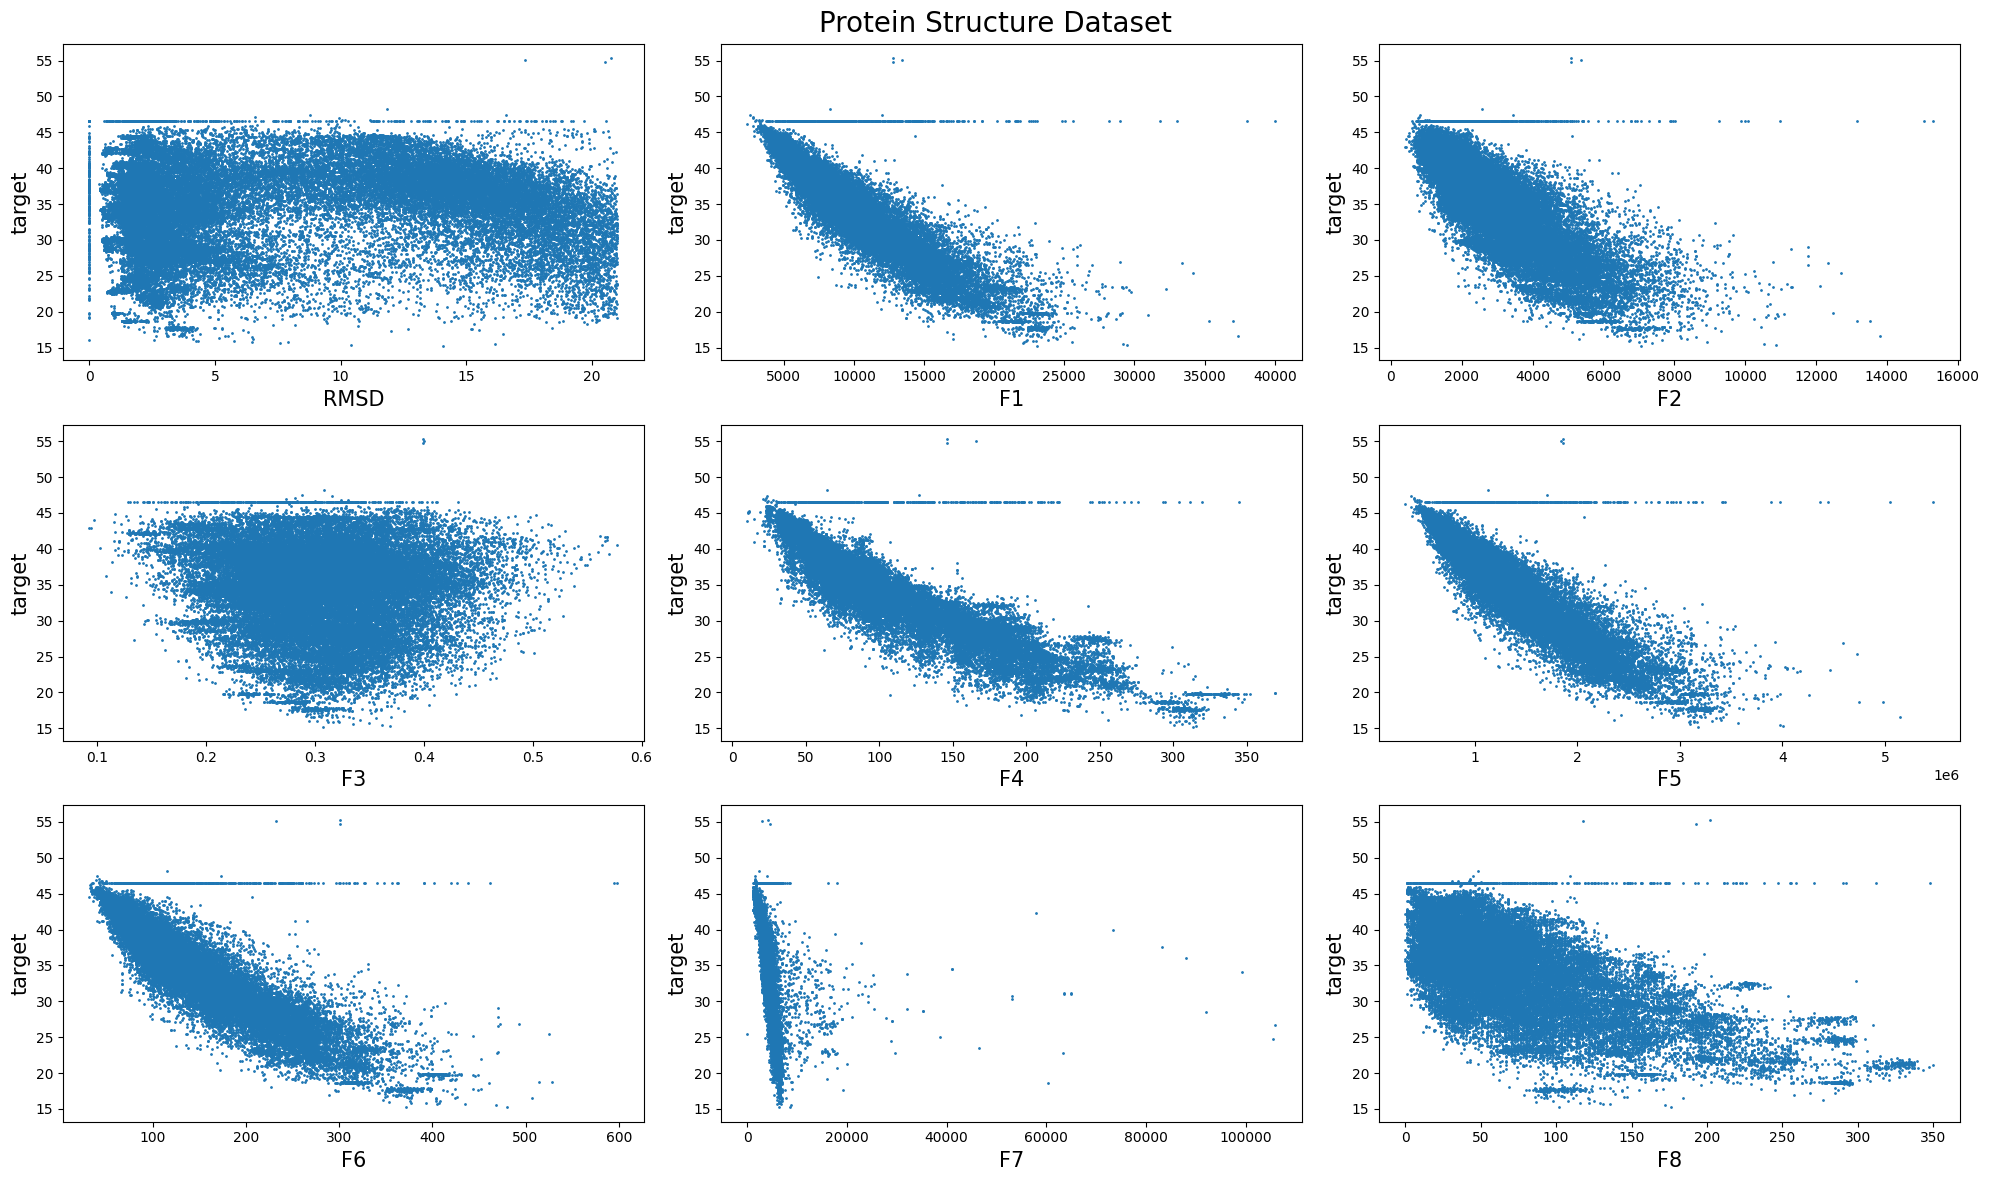

In [3]:
pth="CASP.csv"
data = pd.read_csv(pth)
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

fig, axs=plt.subplots(3,3,figsize=(20, 12))
fig.suptitle("Protein Structure Dataset", fontsize=20)
for i in range(3):
    for j in range(3):
        n=j+i*3
        ft=data.columns[n]
        axs[i,j].scatter(X[:,n],y,s=1)
        axs[i,j].set_xlabel(ft, fontsize=15)
        axs[i,j].set_ylabel("target", fontsize=15)

plt.tight_layout()
plt.savefig('datasetvis',dpi=300)
plt.show()

In [4]:
print(data.head())

     RMSD        F1       F2       F3        F4            F5        F6  \
0  17.284  13558.30  4305.35  0.31754  162.1730  1.872791e+06  215.3590   
1   6.021   6191.96  1623.16  0.26213   53.3894  8.034467e+05   87.2024   
2   9.275   7725.98  1726.28  0.22343   67.2887  1.075648e+06   81.7913   
3  15.851   8424.58  2368.25  0.28111   67.8325  1.210472e+06  109.4390   
4   7.962   7460.84  1736.94  0.23280   52.4123  1.021020e+06   94.5234   

        F7   F8       F9  
0  4287.87  102  27.0302  
1  3328.91   39  38.5468  
2  2981.04   29  38.8119  
3  3248.22   70  39.0651  
4  2814.42   41  39.9147  


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
###################
print("Before Normalization")
#for i in range(5):
#    print(f"features: {X_train[i].tolist()},label: {y_train[i].item()}")
X_train_df = pd.DataFrame(X_train, columns=data.columns[:-1])
X_train_df['Target'] = y_train
print(X_train_df.head())
########################
# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_trainscaled = scaler.fit_transform(y_train.reshape(-1,1))
y_testscaled=scaler.fit_transform(y_test.reshape(-1,1))
#y_pred_original = scaler.inverse_transform(y_trainscaled)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_trainscaled, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_testscaled, dtype=torch.float32).view(-1, 1)
#######################################
print("\n\nAfter Normalization")
X_train_df = pd.DataFrame(X_train.numpy(), columns=data.columns[:-1])
X_train_df['Target'] = y_train.numpy()

# Print first few rows
print(X_train_df.head())
##############################

Before Normalization
     RMSD        F1       F2       F3        F4            F5        F6  \
0   4.332   5233.69  2031.85  0.38822   33.7670  7.424494e+05   67.9476   
1   3.047   7819.23  2085.73  0.26674   79.8767  1.123877e+06  107.8100   
2  14.226   8515.28  2640.61  0.31010   52.4593  1.148044e+06  113.6320   
3  12.719   5924.27  2445.46  0.41278   56.5871  8.373160e+05   81.4286   
4   1.422  15051.30  3870.64  0.25716  184.9900  2.125416e+06  217.6680   

        F7     F8   Target  
0  2541.16   39.0  42.7544  
1  3799.63   51.0  36.0298  
2  4258.61   26.0  35.2010  
3  2495.15  111.0  41.0368  
4  5690.95   75.0  23.0361  


After Normalization
       RMSD        F1        F2        F3        F4        F5        F6  \
0 -0.559394 -1.143797 -0.673319  1.360763 -1.257140 -1.110835 -1.109725   
1 -0.769562 -0.506201 -0.636551 -0.566838 -0.426179 -0.433871 -0.540820   
2  1.058818 -0.334554 -0.257895  0.121183 -0.920279 -0.390979 -0.457730   
3  0.812340 -0.973499 -0.391067 

In [6]:
#define dataloader
print(len(X_train),len(X_test))
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
print(len(train_loader))
# Define optimizers
def get_optimizer(optimizer_name, model):
    if optimizer_name == 'mBGD':
        return optim.SGD(model.parameters(), lr=0.001)
    elif optimizer_name == 'Momentum':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'NAG':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adagrad':
        return optim.Adagrad(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSProp':
        return optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("Unsupported optimizer!")

36584 9146
1144


In [7]:

dict_Tloss = {}
dict_Vloss= {}
dict_Tt={}


In [8]:
#from sklearn.metrics import r2_score

n_epochs=100
optimizers = ['mBGD', 'Momentum', 'NAG', 'Adagrad', 'RMSProp', 'Adam']
for opt_name in optimizers:
    print(f"Training with {opt_name} optimizer...")
    torch.manual_seed(42)
    # Initialize model and optimizer
    model = ANNModel(X_train.shape[1])
    optimizer = get_optimizer(opt_name, model)
    criterion = nn.MSELoss()
    
    # Training loop
    tt=[]
    losses = []
    vlosses=[]
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_start_time = time.time()
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            epoch_loss += loss.item()
        epoch_time = time.time() - epoch_start_time
        #print(epoch_time)
        tt.append(epoch_time)
        losses.append(epoch_loss / len(train_loader))
        if epoch%10 == 0:
            print(f"epoch={epoch} : loss = {epoch_loss / len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            vloss=0
            pred=model(X_test)
            vloss = criterion(pred, y_test)
            vlosses.append(vloss.item())
            """y_=pred.numpy()
            y=y_test.numpy()
            r2s = r2_score(y, y_)
            print(f"R² Score: {r2s:.4f}")"""
    dict_Tloss[opt_name] = losses
    dict_Vloss[opt_name] = vlosses
    dict_Tt[opt_name]=tt

Training with mBGD optimizer...
epoch=0 : loss = 0.3591
epoch=10 : loss = 0.1252
epoch=20 : loss = 0.1167
epoch=30 : loss = 0.1114
epoch=40 : loss = 0.1077
epoch=50 : loss = 0.1052
epoch=60 : loss = 0.1037
epoch=70 : loss = 0.1027
epoch=80 : loss = 0.1019
epoch=90 : loss = 0.1014
Training with Momentum optimizer...
epoch=0 : loss = 0.1678
epoch=10 : loss = 0.1038
epoch=20 : loss = 0.1003
epoch=30 : loss = 0.0985
epoch=40 : loss = 0.0970
epoch=50 : loss = 0.0957
epoch=60 : loss = 0.0945
epoch=70 : loss = 0.0938
epoch=80 : loss = 0.0927
epoch=90 : loss = 0.0919
Training with NAG optimizer...
epoch=0 : loss = 0.1668
epoch=10 : loss = 0.1035
epoch=20 : loss = 0.1000
epoch=30 : loss = 0.0982
epoch=40 : loss = 0.0968
epoch=50 : loss = 0.0954
epoch=60 : loss = 0.0942
epoch=70 : loss = 0.0935
epoch=80 : loss = 0.0924
epoch=90 : loss = 0.0918
Training with Adagrad optimizer...
epoch=0 : loss = 0.1431
epoch=10 : loss = 0.1069
epoch=20 : loss = 0.1038
epoch=30 : loss = 0.1024
epoch=40 : loss = 0.

In [9]:

for name in dict_Tt:
    print(f"optimizer: {name} total training time: {sum(dict_Tt[name]):.3f}sec average time per epoch: {sum(dict_Tt[name])/n_epochs:.3f}sec min train loss: {min(dict_Tloss[name]):.3f} min val loss: {min(dict_Vloss[name]):.3f}")

optimizer: mBGD total training time: 113.167sec average time per epoch: 1.132sec min train loss: 0.101 min val loss: 0.097
optimizer: Momentum total training time: 125.534sec average time per epoch: 1.255sec min train loss: 0.091 min val loss: 0.090
optimizer: NAG total training time: 129.999sec average time per epoch: 1.300sec min train loss: 0.091 min val loss: 0.090
optimizer: Adagrad total training time: 194.091sec average time per epoch: 1.941sec min train loss: 0.099 min val loss: 0.096
optimizer: RMSProp total training time: 206.907sec average time per epoch: 2.069sec min train loss: 0.073 min val loss: 0.089
optimizer: Adam total training time: 270.913sec average time per epoch: 2.709sec min train loss: 0.070 min val loss: 0.090


In [10]:
#print(dict_Tloss[opt_name][3])
print(dict_Tloss)

{'mBGD': [0.3591446770465822, 0.1546884955857861, 0.1453816794165104, 0.13987078343500167, 0.13652268097364714, 0.1337670988738667, 0.1314849908385504, 0.12953336398814108, 0.1279175928044882, 0.12643555407184404, 0.12515353545435814, 0.12394786548680281, 0.12294702916373532, 0.12196673815125612, 0.12112378671446203, 0.12022219332329069, 0.11941278955762412, 0.1186108708705662, 0.11795421827737555, 0.11719127450874271, 0.11666796617275038, 0.11600690743303044, 0.11534439032519614, 0.11549855104624782, 0.11432580919806044, 0.1137427614392856, 0.11321908300840199, 0.11280039745591372, 0.11224273731687816, 0.11184880012398833, 0.11136814482002096, 0.1109073968804474, 0.11045650787443131, 0.11016687913309339, 0.10969992408730819, 0.10928702225397387, 0.11015514924412372, 0.10866504577900303, 0.10822086043287903, 0.10789182049977769, 0.10769095430981003, 0.10737236248739584, 0.10707411966351726, 0.10677965603104525, 0.10648103745758429, 0.10626245368682369, 0.10607731084329551, 0.1058154264

In [11]:
a=[]
for i in range(1,n_epochs+1,1):
    a.append(i)

In [12]:
a=list(range(1,n_epochs+1))
print(a)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


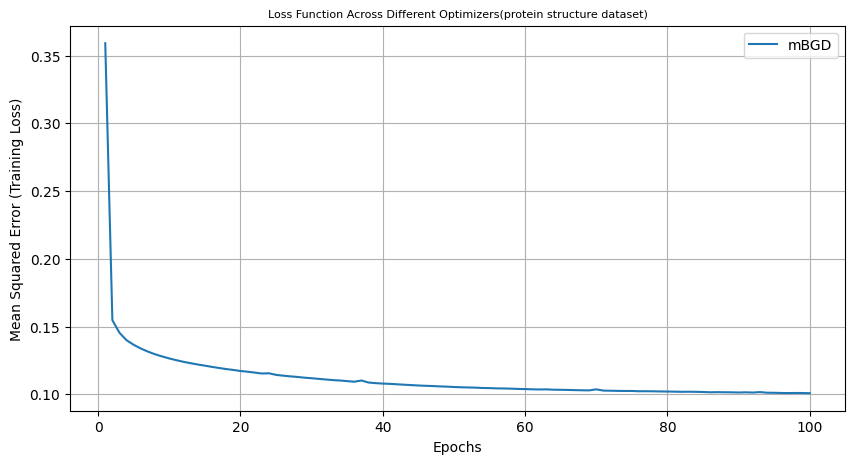

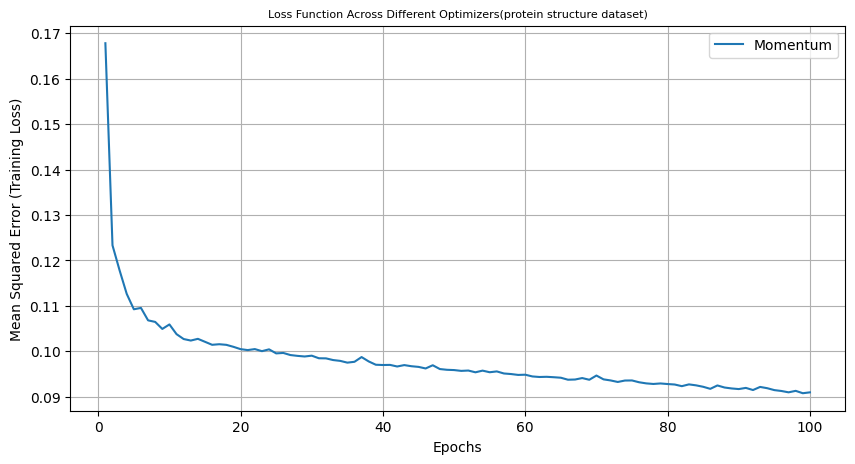

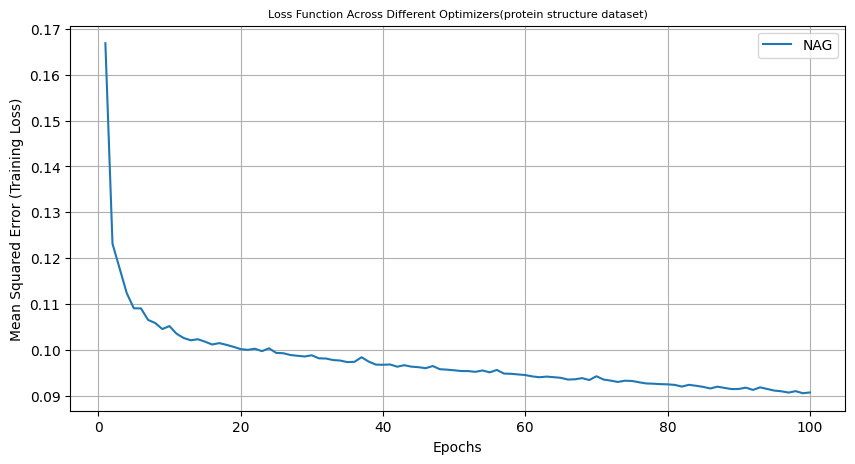

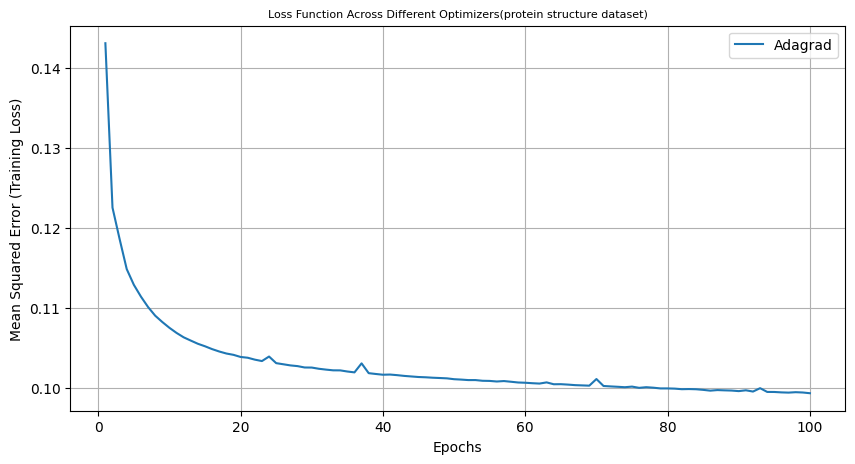

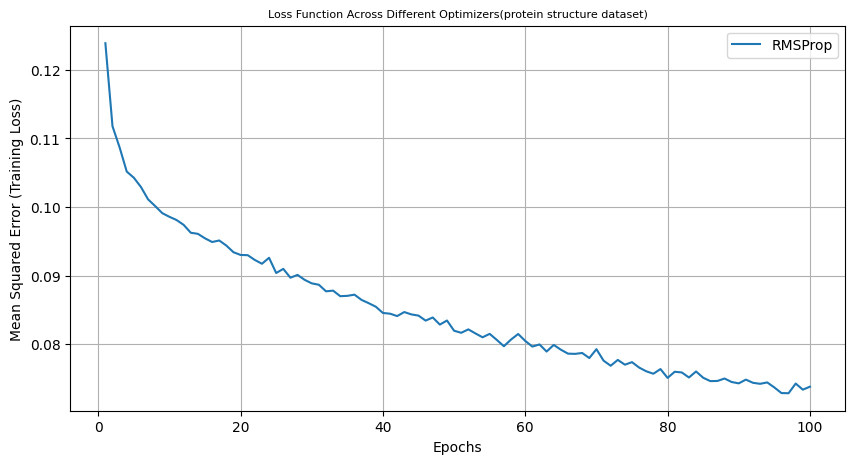

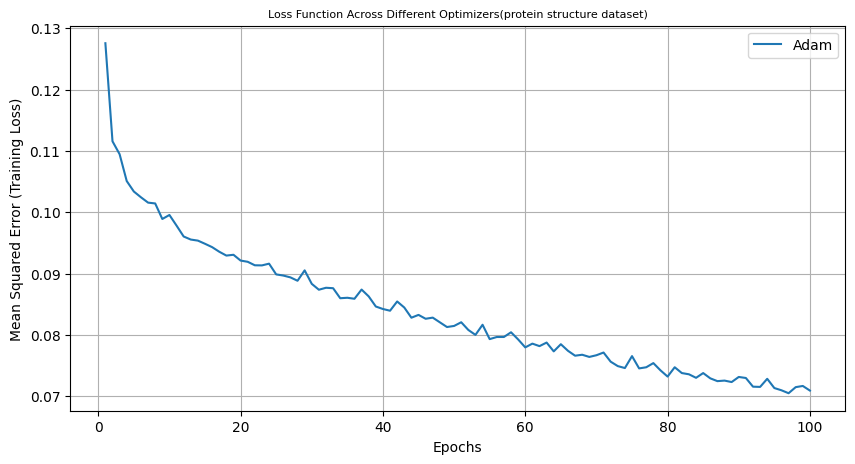

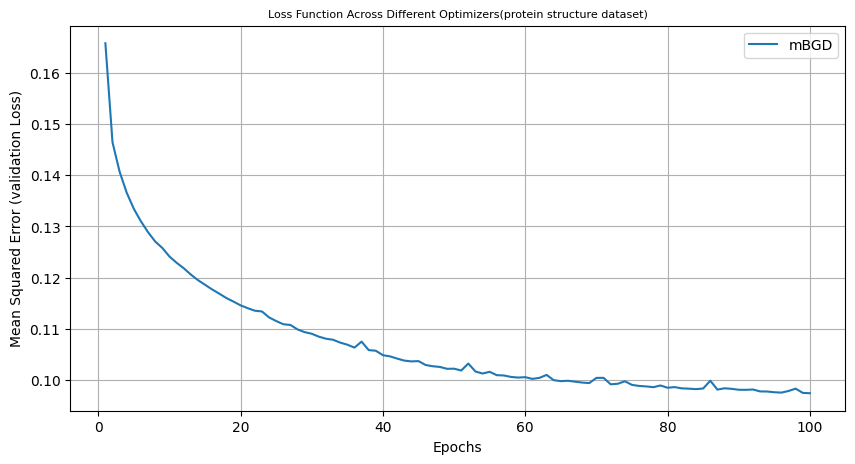

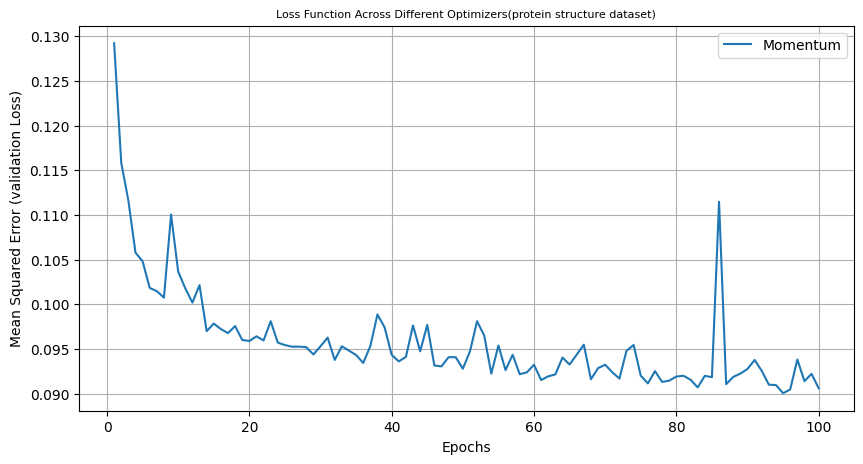

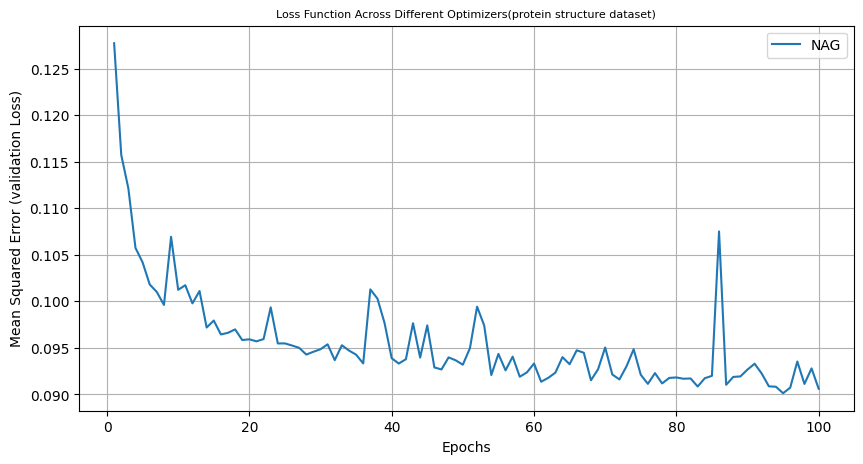

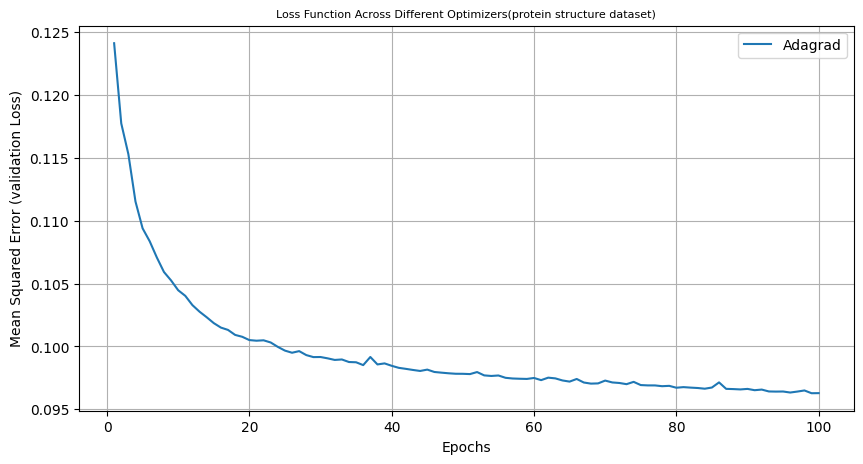

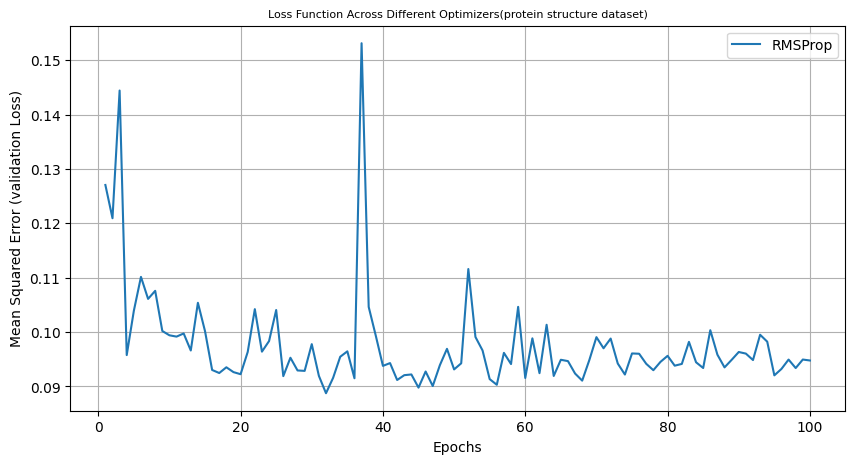

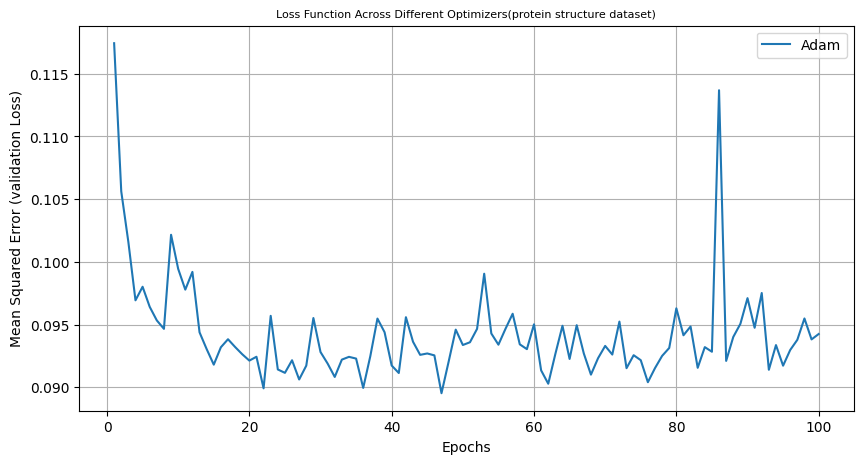

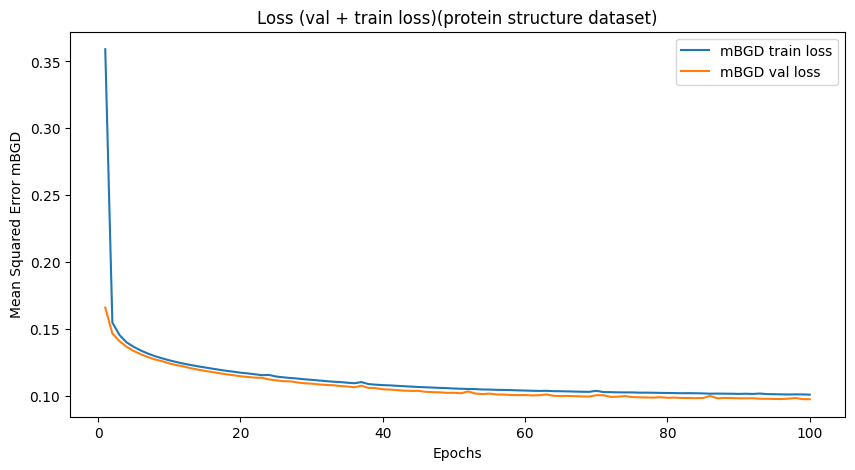

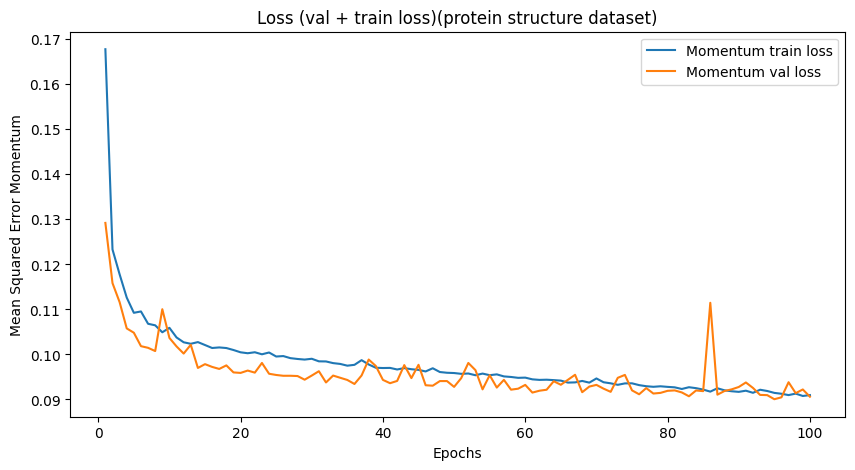

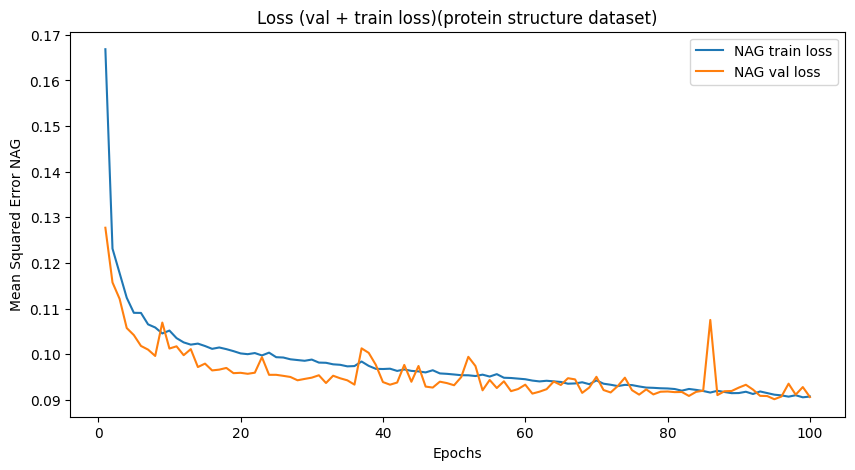

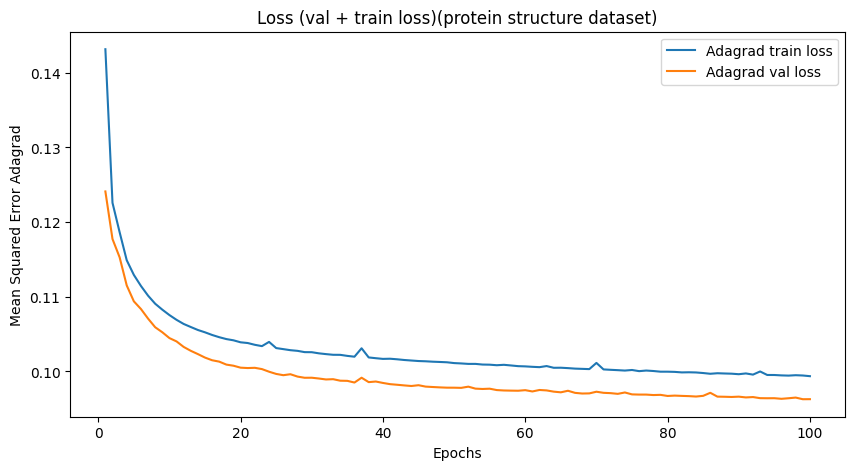

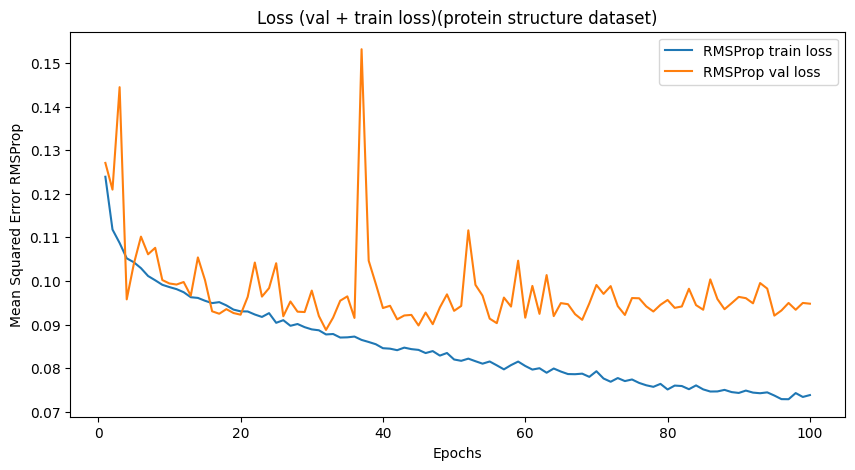

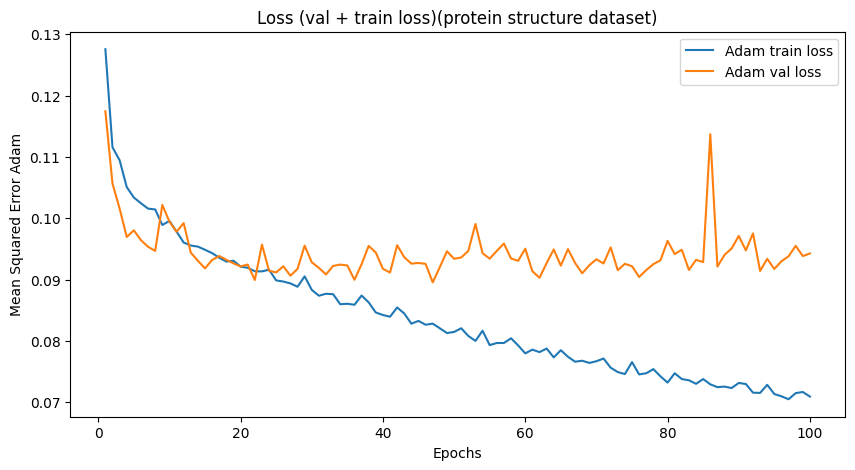

In [13]:
for name, loss in dict_Tloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers(protein structure dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    plt.savefig(f'Training loss {name}.png',dpi=500)
    plt.show()

for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss Function Across Different Optimizers(protein structure dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
    plt.savefig(f'validation loss {name}.png',dpi=500)
    plt.show()


for name, loss in dict_Vloss.items():
    plt.figure(figsize=(10, 5))
    plt.title('Loss (val + train loss)(protein structure dataset)')
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error {name}')
    plt.plot(a,dict_Tloss[name],label=name+' train loss')
    plt.plot(a,dict_Vloss[name],label=name+" val loss")
    plt.legend()
    plt.savefig(f'combined train and val {name}.png',dpi=500)
    plt.show()




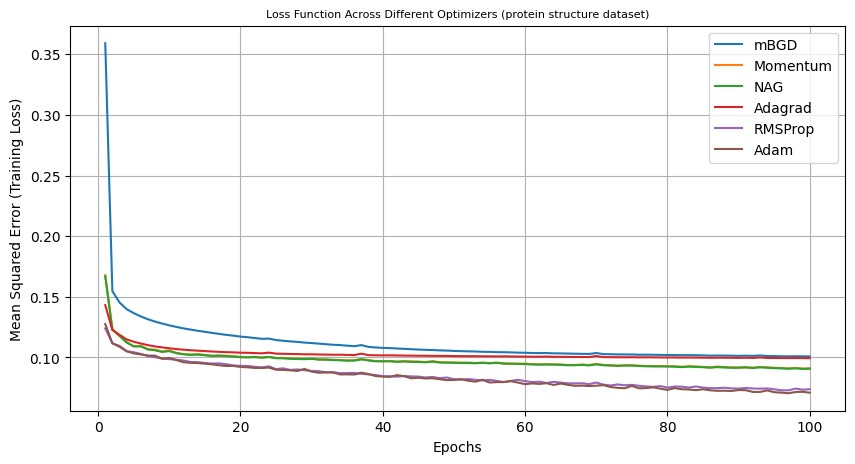

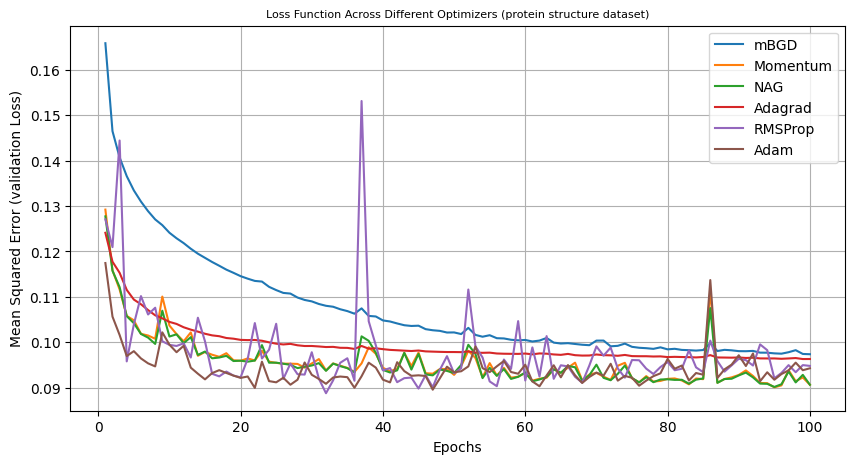

In [14]:
plt.figure(figsize=(10, 5))
for name, loss in dict_Tloss.items():
    plt.title('Loss Function Across Different Optimizers (protein structure dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Training Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined training loss all.png',dpi=500)
plt.show()

plt.figure(figsize=(10, 5))
for name, loss in dict_Vloss.items():
    plt.title('Loss Function Across Different Optimizers (protein structure dataset)',fontsize=8)
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean Squared Error (validation Loss)')
    plt.plot(a,loss, label=name)
    plt.grid(True)
    plt.legend()
plt.savefig(f'combined validation loss all.png',dpi=500)
plt.show()

In [15]:

geeky_file = open('TrainingResults.txt', 'wt') 
geeky_file.write("train loss\n "+str(dict_Tloss)+"\nvalidation loss\n "+str(dict_Vloss)+"\n time\n "+str(dict_Tt)) 
geeky_file.close()